In [ ]:
from utils import h36motion3d as datasets
from utils_chico.PoseDataset import PoseDataset
from utils_chico.data_utils import normal_actions, abnorm_actions, normal_actions_, abnorm_actions_
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize

import torch.nn.functional as F

import warnings
from typing import Callable, Any, Optional, List

import torch
from torch import Tensor
from torch import nn

import time

### Setup

In [3]:
datas = 'chico' # 'h36m' or 'chico'

In [4]:
#FLAGS FOR LOADING THE DATASET if datas == 'h36m': path = r'C:\Users\108978\Desktop\seq2seq_GCN\h3.6m\dataset' else: path = r'data\CHICO\dataset'

input_n=10 # number of frames to train on(default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames for H3.6M (default=1)

if datas == 'h36m':
    joints_to_consider=22  #joints for  H3.6M(default=22 for coordinates)
else:
    joints_to_consider=15

#FLAGS FOR THE MODEL
tcnn_layers=4 # number of layers for the Temporal Convolution of the Decoder (default=4)
tcnn_kernel_size=[3,3] # kernel for the T-CNN layers (default=[3,3])
input_dim=3 # dimensions of the input coordinates(default=3)
st_gcnn_dropout=0.1 #(default=0.1)
tcnn_dropout=0.0  ##(default=0.0)


#FLAGS FOR THE TRAINING
mode='test' #choose either train or test mode

if datas == 'h36m':
    n_epochs=61 #61
    batch_size=256
    batch_size_test=8
    lr=1e-01 # learning rate
    use_scheduler=True # use MultiStepLR scheduler
    milestones=[10,25,30,37] # the epochs after which the learning rate is adjusted by gamma ########### SOTA [25,30,37]
else:
    n_epochs=61
    batch_size=256
    batch_size_test=8
    lr=1e-02 # learning rate
    use_scheduler=True # use MultiStepLR scheduler
    milestones=[10, 25, 30,40]   # the epochs after which the learning rate is adjusted by gamma ########### SOTA [25,30,37]
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
clip_grad=None # select max norm to clip gradients
model_path= r'C:\Users\108978\Desktop\seq2seq_GCN\checkpoints' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load
#model_name = 'STSGCN' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

### Build Model

In [5]:
from models.SeSGCN_teacher import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


model= Model(input_dim,input_n,
                        output_n,st_gcnn_dropout,joints_to_consider,tcnn_layers,tcnn_kernel_size,tcnn_dropout).to(device)

optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=1e-05)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 53591


### Train

In [7]:
def train(dataset,vald_dataset):
  train_loss = []
  val_loss = []
  val_loss_best = 1000
  #dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
  print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

  #vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)
  print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
  vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])



  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          if datas == 'h36m':
            sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
            sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)
          else:
            sequences_train=batch[:, :input_n,].view(-1,input_n,joints_to_consider,3).permute(0,3,1,2)
            sequences_gt=batch[:, input_n:input_n+output_n].view(-1,output_n,joints_to_consider,3)#.permute(0,3,1,2)


          optimizer.zero_grad()

          sequences_predict=model(sequences_train).permute(0,1,3,2)

          loss=mpjpe_error(sequences_predict,sequences_gt)


          if cnt % 200 == 0:
            print('[%d, %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim

              if datas == 'h36m':
                sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
                sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)
              else:
                sequences_train=batch[:, :input_n,].view(-1,input_n,joints_to_consider,3).permute(0,3,1,2)
                sequences_gt=batch[:, input_n:input_n+output_n].view(-1,output_n,joints_to_consider,3)#.permute(0,3,1,2)

              sequences_predict=model(sequences_train).permute(0,1,3,2)
              loss=mpjpe_error(sequences_predict,sequences_gt)
              if cnt % 200 == 0:
                        print('[%d, %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))
              running_loss+=loss*batch_dim
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n
            torch.save(model.state_dict(),model_name+'_STS_best')

      if use_scheduler:
        scheduler.step()


      if (epoch+1)%10==0:
        print('----saving model-----')
        torch.save(model.state_dict(),model_name+'_STS')
        plt.figure(1)
        plt.plot(train_loss, 'r', label='Train loss')
        plt.plot(val_loss, 'g', label='Val loss')
        plt.legend()
        plt.show()

      if (epoch+1)==n_epochs:
        print('----saving model-----')
        torch.save(model.state_dict(),model_name+'_STS')


### Trainer

In [19]:
import os
path = os.path.join("data","CHICO","dataset")

>>> Training dataset length: 115475
>>> Validation dataset length: 16187
[1,     1]  training loss: 956.662
[1,   201]  training loss: 928.608
[1,   401]  training loss: 865.038
[1,     1]  validation loss: 864.086
[2,     1]  training loss: 842.012
[2,   201]  training loss: 797.755
[2,   401]  training loss: 764.874
[2,     1]  validation loss: 750.108
[3,     1]  training loss: 741.916
[3,   201]  training loss: 613.229
[3,   401]  training loss: 590.715
[3,     1]  validation loss: 595.573
[4,     1]  training loss: 595.961
[4,   201]  training loss: 583.801
[4,   401]  training loss: 568.670
[4,     1]  validation loss: 567.017
[5,     1]  training loss: 577.047
[5,   201]  training loss: 562.372
[5,   401]  training loss: 547.488
[5,     1]  validation loss: 540.285
[6,     1]  training loss: 547.846
[6,   201]  training loss: 541.193
[6,   401]  training loss: 528.793
[6,     1]  validation loss: 506.729
[7,     1]  training loss: 525.344
[7,   201]  training loss: 523.855
[7,  

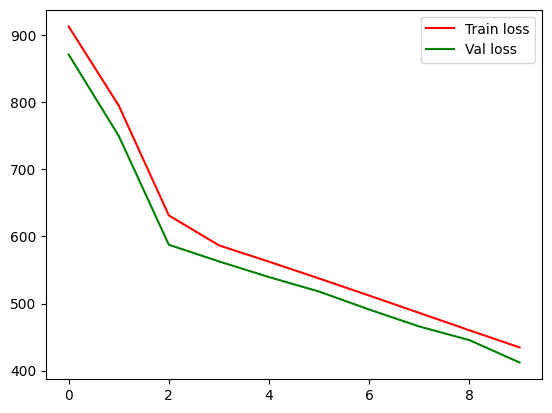

[11,     1]  training loss: 422.451
[11,   201]  training loss: 416.595
[11,   401]  training loss: 422.563
[11,     1]  validation loss: 411.947
[12,     1]  training loss: 414.994
[12,   201]  training loss: 426.713
[12,   401]  training loss: 411.292
[12,     1]  validation loss: 408.292
[13,     1]  training loss: 415.986
[13,   201]  training loss: 409.790
[13,   401]  training loss: 409.596
[13,     1]  validation loss: 400.518
[14,     1]  training loss: 410.805
[14,   201]  training loss: 409.956
[14,   401]  training loss: 414.387
[14,     1]  validation loss: 399.450
[15,     1]  training loss: 414.492
[15,   201]  training loss: 400.676
[15,   401]  training loss: 408.965
[15,     1]  validation loss: 395.398
[16,     1]  training loss: 408.918
[16,   201]  training loss: 408.181
[16,   401]  training loss: 401.243
[16,     1]  validation loss: 401.098
[17,     1]  training loss: 403.222
[17,   201]  training loss: 409.851
[17,   401]  training loss: 395.078
[17,     1]  val

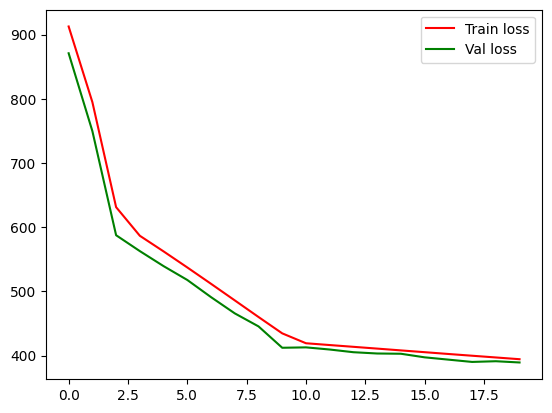

[21,     1]  training loss: 391.464
[21,   201]  training loss: 397.379
[21,   401]  training loss: 396.835
[21,     1]  validation loss: 395.742
[22,     1]  training loss: 385.237
[22,   201]  training loss: 385.237
[22,   401]  training loss: 388.585
[22,     1]  validation loss: 381.508
[23,     1]  training loss: 388.217
[23,   201]  training loss: 388.686
[23,   401]  training loss: 391.421
[23,     1]  validation loss: 376.292
[24,     1]  training loss: 389.452
[24,   201]  training loss: 381.162
[24,   401]  training loss: 385.246
[24,     1]  validation loss: 381.016
[25,     1]  training loss: 375.790
[25,   201]  training loss: 376.827
[25,   401]  training loss: 381.015
[25,     1]  validation loss: 382.327
[26,     1]  training loss: 393.138
[26,   201]  training loss: 388.409
[26,   401]  training loss: 372.993
[26,     1]  validation loss: 376.604
[27,     1]  training loss: 384.914
[27,   201]  training loss: 380.340
[27,   401]  training loss: 383.058
[27,     1]  val

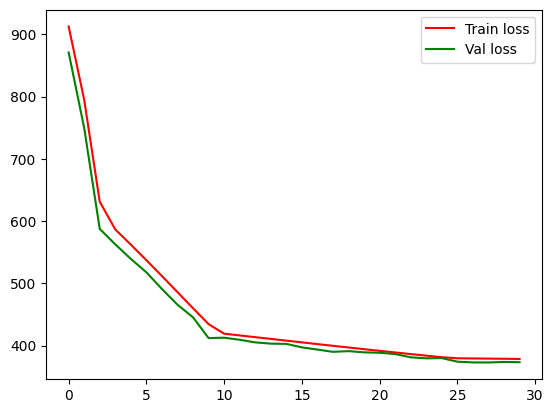

[31,     1]  training loss: 370.675
[31,   201]  training loss: 375.894
[31,   401]  training loss: 381.870
[31,     1]  validation loss: 371.472
[32,     1]  training loss: 381.635
[32,   201]  training loss: 380.115
[32,   401]  training loss: 376.215
[32,     1]  validation loss: 377.136
[33,     1]  training loss: 380.562
[33,   201]  training loss: 375.736
[33,   401]  training loss: 382.170
[33,     1]  validation loss: 377.443
[34,     1]  training loss: 383.095
[34,   201]  training loss: 374.608
[34,   401]  training loss: 382.745
[34,     1]  validation loss: 373.566
[35,     1]  training loss: 378.546
[35,   201]  training loss: 375.089
[35,   401]  training loss: 380.309
[35,     1]  validation loss: 372.552
[36,     1]  training loss: 377.098
[36,   201]  training loss: 373.340
[36,   401]  training loss: 378.663
[36,     1]  validation loss: 372.538
[37,     1]  training loss: 378.465
[37,   201]  training loss: 371.491
[37,   401]  training loss: 379.543
[37,     1]  val

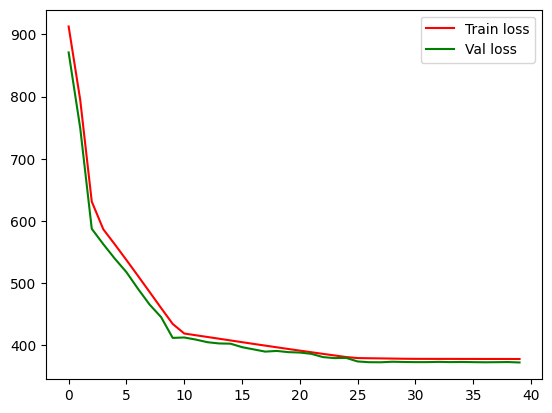

[41,     1]  training loss: 378.222
[41,   201]  training loss: 380.774
[41,   401]  training loss: 388.214
[41,     1]  validation loss: 372.768
[42,     1]  training loss: 376.073
[42,   201]  training loss: 382.558
[42,   401]  training loss: 376.565
[42,     1]  validation loss: 377.134
[43,     1]  training loss: 387.240
[43,   201]  training loss: 371.323
[43,   401]  training loss: 371.044
[43,     1]  validation loss: 365.228
[44,     1]  training loss: 378.665
[44,   201]  training loss: 378.775
[44,   401]  training loss: 379.719
[44,     1]  validation loss: 378.075
[45,     1]  training loss: 379.942
[45,   201]  training loss: 381.470
[45,   401]  training loss: 378.383
[45,     1]  validation loss: 371.335
[46,     1]  training loss: 379.414
[46,   201]  training loss: 376.624
[46,   401]  training loss: 378.643
[46,     1]  validation loss: 372.478
[47,     1]  training loss: 373.902
[47,   201]  training loss: 371.695
[47,   401]  training loss: 374.903
[47,     1]  val

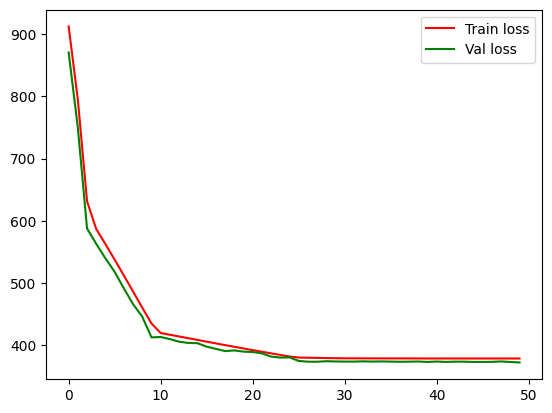

[51,     1]  training loss: 379.197
[51,   201]  training loss: 374.801
[51,   401]  training loss: 385.884
[51,     1]  validation loss: 374.771
[52,     1]  training loss: 387.615
[52,   201]  training loss: 379.061
[52,   401]  training loss: 381.111
[52,     1]  validation loss: 377.111
[53,     1]  training loss: 379.320
[53,   201]  training loss: 378.672
[53,   401]  training loss: 372.512
[53,     1]  validation loss: 371.804
[54,     1]  training loss: 388.754
[54,   201]  training loss: 381.537
[54,   401]  training loss: 367.987
[54,     1]  validation loss: 372.081
[55,     1]  training loss: 382.831
[55,   201]  training loss: 376.245
[55,   401]  training loss: 378.119
[55,     1]  validation loss: 374.702
[56,     1]  training loss: 377.114
[56,   201]  training loss: 379.093
[56,   401]  training loss: 372.944
[56,     1]  validation loss: 376.864
[57,     1]  training loss: 374.564
[57,   201]  training loss: 385.385
[57,   401]  training loss: 381.767
[57,     1]  val

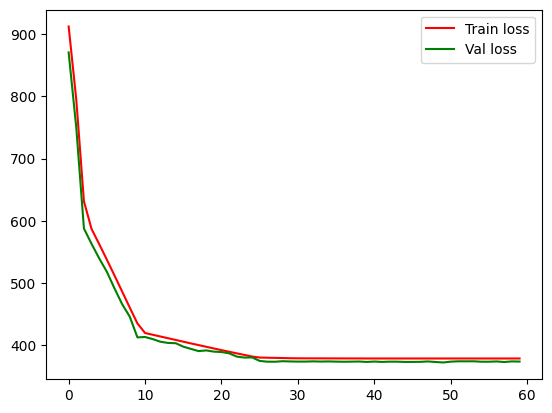

In [13]:
# Load Data
if datas == 'h36m':
    dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
    vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)
else:
    dataset = PoseDataset(path,'train',input_n, output_n, actions=normal_actions, win_stride=1)
    vald_dataset = PoseDataset(path,'validation', input_n,output_n, actions=normal_actions, win_stride=1)

train(dataset,vald_dataset)

### Test

In [20]:
if datas == 'h36m':
  def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    kkk=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          sss = time.time()
          sequences_predict = model(sequences_train)
          totalll += time.time()-sss
          kkk += 1
          sequences_predict=sequences_predict.permute(0,1,3,2).contiguous().view(-1,output_n,len(dim_used))



          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/kkk)

else:
  def test(ckpt, fps=25):
    all_mpjpe = []
    model.load_state_dict(torch.load(ckpt)) # newSeSGCN256
    print('model loaded')
    model.eval()
    accum_loss=0
    real_accum = 0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    kkk=0
    for action in normal_actions:
      mpjpe_joi, mpjpe_ali = np.zeros([fps]),np.zeros([fps])
      running_loss=0
      running_loss_real=0
      n=0
      dataset_test = PoseDataset(path,'test',input_n,output_n, actions=[action], win_stride=1)
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          #sequences_train=batch[:, 0:input_n, :, :].permute(0,3,1,2).float()
          #sequences_gt=batch[:, input_n:input_n+output_n, :,:].float()
          sequences_train=batch[:, :input_n,].view(-1,input_n,joints_to_consider,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n]#.view(-1,output_n,joints_to_consider,3).permute(0,3,1,2)


          sss = time.time()
          sequences_predict = model(sequences_train)
          totalll += time.time()-sss
          kkk += 1
          sequences_predict=sequences_predict.permute(0,1,3,2).contiguous()
          #print(sequences_predict.shape, sequences_gt.shape)
          #sequences_predict*= 1.4357
          #sequences_gt*= 1.4357
          tmp_joi = torch.sum(torch.mean(torch.norm(sequences_predict - sequences_gt, dim=3), dim=2), dim=0)
          mpjpe_joi += tmp_joi.cpu().data.numpy()


          loss=mpjpe_error(sequences_predict,sequences_gt)#*1000

          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      print(str(action),': ', str((running_loss/n).item()))
      mpjpe_joi = mpjpe_joi/n
      out_print_frame = [9,fps-1]
      res_dic = {"mpjpe_joi": mpjpe_joi[out_print_frame]}
      print('Error at each output frame:\n Frame number:{}\n Error:{}'.format(out_print_frame,res_dic))
      all_mpjpe.append(mpjpe_joi[out_print_frame])
      n_batches+=n
    print('Average: '+str((accum_loss/n_batches).item()))
    print(np.array(all_mpjpe).mean(0))
    print('Prediction time: ', totalll/kkk)






### Tester

In [22]:
import os
print(f"dataset = {datas}, framerate = {output_n}")
test(ckpt=os.path.join("checkpoints",datas, f"{datas}_3d_{output_n}frames_Teacher"), fps=output_n)

dataset = chico, framerate = 25
model loaded
hammer.pkl :  45.90226745605469
Error at each output frame:
 Frame number:[9, 24]
 Error:{'mpjpe_joi': array([46.63129935, 58.22013697])}
lift.pkl :  74.99072265625
Error at each output frame:
 Frame number:[9, 24]
 Error:{'mpjpe_joi': array([ 65.42175737, 118.50891062])}
place-hp.pkl :  54.02309799194336
Error at each output frame:
 Frame number:[9, 24]
 Error:{'mpjpe_joi': array([48.73609563, 81.26187472])}
place-lp.pkl :  57.67970275878906
Error at each output frame:
 Frame number:[9, 24]
 Error:{'mpjpe_joi': array([51.76618695, 86.41363459])}
polish.pkl :  46.706180572509766
Error at each output frame:
 Frame number:[9, 24]
 Error:{'mpjpe_joi': array([41.67832585, 72.31191866])}
span_heavy.pkl :  67.7001724243164
Error at each output frame:
 Frame number:[9, 24]
 Error:{'mpjpe_joi': array([ 60.52087863, 103.29989399])}
span_light.pkl :  63.70423889160156
Error at each output frame:
 Frame number:[9, 24]
 Error:{'mpjpe_joi': array([58.073

### Load Model and Save Masks

In [25]:
model.load_state_dict(torch.load(os.path.join("checkpoints",datas, f"{datas}_3d_{output_n}frames_Teacher")))

<All keys matched successfully>

In [26]:
A_space = []
A_space.append(model.st_gcnns[0].gcn.A)
A_space.append(model.st_gcnns[1].gcn.A)
A_space.append(model.st_gcnns[2].gcn.A)
A_space.append(model.st_gcnns[3].gcn.A)
A_space.append(model.st_gcnns[4].gcn.A)

A_time = []
A_time.append(model.st_gcnns[0].gcn.T)
A_time.append(model.st_gcnns[1].gcn.T)
A_time.append(model.st_gcnns[2].gcn.T)
A_time.append(model.st_gcnns[3].gcn.T)
A_time.append(model.st_gcnns[4].gcn.T)

In [27]:
class InteractionMask(nn.Module):
    def __init__(self):
        super(InteractionMask, self).__init__()

        self.spatial_output = nn.Sigmoid()
        self.spatial_asymmetric_convolutions = nn.ModuleList()
        self.temporal_asymmetric_convolutions = nn.ModuleList()


        self.spatial_output = nn.Tanh()
        self.temporal_output = nn.Tanh()



    def forward(self, dense_spatial_interaction,dense_temporal_interaction, threshold):

        spatial_interaction_mask = self.spatial_output(dense_spatial_interaction)
        temporal_interaction_mask = self.temporal_output(dense_temporal_interaction)

        spatial_zero = torch.zeros_like(spatial_interaction_mask, device='cuda')
        temporal_zero = torch.zeros_like(temporal_interaction_mask, device='cuda')

        spatial_ones = torch.ones_like(spatial_interaction_mask, device='cuda')
        temporal_ones = torch.ones_like(temporal_interaction_mask, device='cuda')

        spatial_interaction_mask = torch.where(torch.abs(spatial_interaction_mask) > threshold, spatial_ones,spatial_zero)
        temporal_interaction_mask = torch.where(torch.abs(temporal_interaction_mask) > threshold, temporal_ones, temporal_zero)


        return spatial_interaction_mask, temporal_interaction_mask

In [28]:
masker = InteractionMask()
maskA, maskT = [], []
for i in range(5):
    A_mask, T_mask = masker(A_space[i], A_time[i], threshold=0.03)
    maskA.append(np.array(A_mask.detach().cpu()))
    maskT.append(np.array(T_mask.detach().cpu()))

space_zero = np.array([(maskA[i]==0).sum() for i in range(5)]).sum()
time_zero = np.array([(maskT[i]==0).sum() for i in range(5)]).sum()

print('Space zeros %: ', space_zero/len(np.array(maskA).reshape(-1))*100)
print('Time zeros %: ', time_zero/len(np.array(maskT).reshape(-1))*100)

Space zeros %:  20.924444444444447
Time zeros %:  21.013333333333335


In [29]:
np.save('maskT.npy', np.array(maskT))
np.save('maskA.npy', np.array(maskA))